In [1]:
! pip install textblob

In [2]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.4 MB/s eta 0:00:00


In [3]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [4]:
!pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=0ac466ccfe7c9a6ae32580485ad6f9f6525cace835a9666632cedb6046a2c8c5
  Stored in directory: /root/.cache/pip/wheels/e6/66/9c/712044a983337f5d44f90abcd244bd4b8ad28ee64750404b50
Successfully built wordninja


In [5]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

import string
import re
import emoji
import wordninja
import os
import sys
import ast

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spellchecker import SpellChecker
from collections import Counter
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.graph_objects as go

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
tt = pd.read_csv('./tiktok_google_play_reviews.csv', low_memory=False)

In [8]:
tt.rename(columns={'content': 'reviews', 'score': 'rating', 'thumbsUpCount':'likes','reviewCreatedVersion': 'appversion', 'at': 'timestamp',}
          , inplace=True)

In [9]:
tt.drop(columns=['reviewId' ,'userName','userImage','replyContent','repliedAt'], inplace=True)
print(tt.columns.values)

['reviews' 'rating' 'likes' 'appversion' 'timestamp']


In [10]:
tt['timestamp'] = pd.to_datetime(tt['timestamp'], errors='coerce',dayfirst=True)
tt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9773 entries, 0 to 9772
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   reviews     9773 non-null   object        
 1   rating      9773 non-null   int64         
 2   likes       9773 non-null   int64         
 3   appversion  7070 non-null   object        
 4   timestamp   9772 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 381.9+ KB


<ipython-input-10-3ff27684f13a>:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  tt['timestamp'] = pd.to_datetime(tt['timestamp'], errors='coerce',dayfirst=True)


In [11]:
missing_values = tt.isnull().sum()

print("Missing values before removal:")
print(missing_values)

tt = tt.dropna(subset=['reviews'])
missing_values = tt.isnull().sum()

print("\nMissing values after removal:")
print(missing_values)

Missing values before removal:
reviews          0
rating           0
likes            0
appversion    2703
timestamp        1
dtype: int64

Missing values after removal:
reviews          0
rating           0
likes            0
appversion    2703
timestamp        1
dtype: int64


In [12]:
def replace_emojis_with_text(text):
    demojized_text = emoji.demojize(text)

    split_text = ' '.join(wordninja.split(demojized_text))

    emoji_count = len([char for char in text if char in emoji.EMOJI_DATA])

    return split_text, emoji_count

tt['reviews_original'] = tt['reviews']
tt['reviews'], tt['emoji_count'] = zip(*tt['reviews'].apply(replace_emojis_with_text))

total_emojis_replaced = tt['emoji_count'].sum()
print(f"Total emojis replaced: {total_emojis_replaced}")

print(tt[['reviews_original', 'reviews']].tail())

tt.drop(columns=['emoji_count'], inplace=True)
tt.drop(columns=['reviews_original'], inplace=True)

Total emojis replaced: 4084
           reviews_original                    reviews
9768    👌 it's really great  OK hand it's really great
9769  Waste app in the ever      Waste app in the ever
9770                   Nice                       Nice
9771     I do not get test.          I do not get test
9772               Nice app                   Nice app


In [13]:
tt['reviews'] = tt['reviews'].str.lower()
tt['reviews'] = tt['reviews'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [14]:
import nltk
from nltk.corpus import stopwords  # Import the stopwords module
from nltk.tokenize import word_tokenize  # Import word_tokenize for tokenization

# Download required NLTK resources
nltk.download('punkt')  # Download the punkt tokenizer
nltk.download('stopwords')  # Download the stopwords corpus

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    try:
        words = word_tokenize(text)  # Tokenize the text
        filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
        return ' '.join(filtered_words)  # Join the filtered words back into a string
    except Exception as e:
        print(f"Error cleaning text: {text} - {e}")
        return text

# Apply the function to your DataFrame
tt['reviews_nostopwords'] = tt['reviews'].apply(remove_stopwords)

# Display the results
print(tt[['reviews', 'reviews_nostopwords']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Streaming output truncated to the last 5000 lines.

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Error cleaning text: great app - 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nl

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    try:
        words = word_tokenize(text)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)
    except Exception as e:
        print(f"Error lemmatizing text: {text} - {e}")
        return text

tt['reviews_lemmatized'] = tt['reviews_nostopwords'].apply(lemmatize_text)

print(tt[['reviews_nostopwords', 'reviews_lemmatized']].head())
tt.drop(columns=['reviews_nostopwords'], inplace=True)

Streaming output truncated to the last 5000 lines.

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Error lemmatizing text: great app - 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib

In [16]:
from spellchecker import SpellChecker

spell = SpellChecker()

def remove_misspelled_words(review):
    words = review.split()
    misspelled = spell.unknown(words)
    cleaned_review = ' '.join([word for word in words if word not in misspelled])

    return cleaned_review, misspelled

# Apply the function to the reviews
tt['reviews_no_misspelled_words'], tt['misspelled_words'] = zip(*tt['reviews_lemmatized'].apply(remove_misspelled_words))

# Now filter rows with misspelled words
misspelled_rows = tt[tt['misspelled_words'].apply(lambda x: len(x) > 0)]

total_removed = tt['misspelled_words'].apply(len).sum()

print(f"Total words removed: {total_removed}")

all_misspelled = [word for sublist in tt['misspelled_words'] for word in sublist]
first_100_misspelled = all_misspelled[:100]

print("\nSummary of the first 100 removed misspelled words:")
print(set(first_100_misspelled))  # Remove duplicates

tt.drop(columns=['reviews_lemmatized'], inplace=True)
tt.drop(columns=['misspelled_words'], inplace=True)

Total words removed: 10232

Summary of the first 100 removed misspelled words:
{'sss', 've', 'arent', 'tik', 'eeeeee', 'im', 'vid', 'doesnt', 'app', 'lol', 'tok', 'thats', 'dont', 'favourite', 'menos', 'll', 'mers', 'mikey', 'elo', 'insta', 'kwai', 'shii', 'qadeer', 'aw', 'apps', 'ive', 'havent', 'rafi', 'plz', 'khali', 'sms', 'didnt', 'gud', 'olds', 'www', 'bigest', 'def', 'comp', 'tley', 'luv', 'bc', 'rehan', 'ttt', 'da'}


In [17]:
redundant_phrases = [
    'tiktok', 'video', 'app', 'content','feature', 'update', 'platform', 'post','social media','service', 'face', 'account', 'download', 'follower']

def remove_redundant_words(text, redundant_phrases):
    for phrase in redundant_phrases:
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)
    return text

tt['reviews_cleaned'] = tt['reviews_no_misspelled_words'].apply(lambda x: remove_redundant_words(x, redundant_phrases))
tt.drop(columns=['reviews_no_misspelled_words'], inplace=True)

In [18]:
empty_string_rows = tt[tt['reviews_cleaned'] == '']

print(f"Number of rows with empty strings: {empty_string_rows.shape[0]}")

tt['reviews_cleaned'] = tt['reviews_cleaned'].replace('', np.nan)

Number of rows with empty strings: 506


In [22]:
tt = tt.dropna(subset=['reviews_cleaned'])
missing_values = tt.isnull().sum()
import nltk
nltk.download('punkt_tab')


print(tt.shape)
print (missing_values)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


(9267, 6)
reviews               0
rating                0
likes                 0
appversion         2526
timestamp             1
reviews_cleaned       0
dtype: int64


In [24]:
tt['reviews_tokenize'] = tt['reviews_cleaned'].apply(lambda x: word_tokenize(x))

In [25]:
plt.style.use('fivethirtyeight')

cp = sns.color_palette()
analyzer = SentimentIntensityAnalyzer()

In [26]:
emptyline=[]
for row in tt['reviews_cleaned']:
    vs=analyzer.polarity_scores(row)
    emptyline.append(vs)

tt_sentiments=pd.DataFrame(emptyline)
tt_sentiments.head()

,neg,neu,pos,compound
0,0.688,0.312,0.000,-0.2960
1,0.000,0.213,0.787,0.8126
2,0.073,0.927,0.000,-0.6297
3,0.000,0.481,0.519,0.9325
4,0.000,1.000,0.000,0.0000


In [27]:
tt_merged = pd.concat([tt.reset_index(drop=True), tt_sentiments], axis=1)
tt_merged.head()

,reviews,rating,likes,appversion,timestamp,reviews_cleaned,reviews_tokenize,neg,neu,pos,compound
0,no words,5,0,27.1.3,2022-11-29 21:55:37,no words,"[no, words]",0.688,0.312,0.000,-0.2960
1,great fun app so far,5,0,NaN,2022-11-29 21:55:04,great fun so far,"[great, fun, so, far]",0.000,0.213,0.787,0.8126
2,the app would get a higher rating but i litera...,1,0,27.1.3,2022-11-29 21:54:48,the would get a higher rating but i literally ...,"[the, would, get, a, higher, rating, but, i, l...",0.073,0.927,0.000,-0.6297
3,i wish i could give this a percent rating i l...,5,0,NaN,2022-11-29 21:54:35,i wish i could give this a percent rating i lo...,"[i, wish, i, could, give, this, a, percent, ra...",0.000,0.481,0.519,0.9325
4,pictures and record,5,0,NaN,2022-11-29 21:54:21,pictures and record,"[pictures, and, record]",0.000,1.000,0.000,0.0000


In [28]:
tt_merged.drop(columns=['neg','neu','pos'], inplace=True)

In [29]:
tt_merged['Sentiment'] = np.where(
    tt_merged['compound'] >= 0.35, 'Positive',
    np.where(tt_merged['compound'] <= -0.35 ,'Negative', 'Neutral')
)

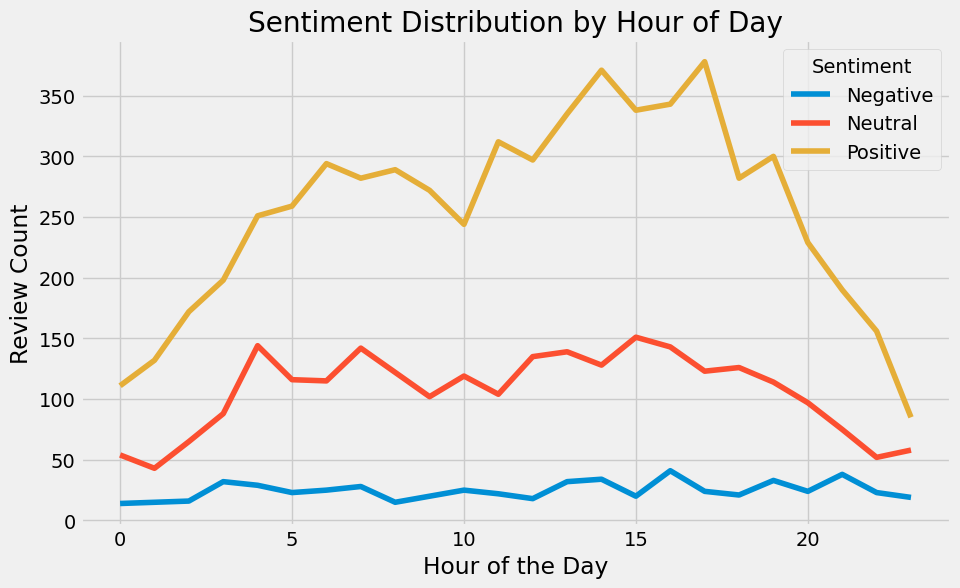

In [30]:
# Stacked Bar Chart, Time(Hour) against Sentiment

# Extract the hour from the timestamp
tt_merged['hour'] = tt_merged['timestamp'].dt.hour

sentiment_over_time_of_day = tt_merged.groupby(['hour', 'Sentiment']).size().unstack()

sentiment_over_time_of_day.plot(kind='line', figsize=(10, 6), title="Sentiment Distribution by Hour of Day")
plt.xlabel('Hour of the Day')
plt.ylabel('Review Count')
plt.show()

In [31]:
# Drop only the columns that exist in the DataFrame
columns_to_drop = ['appversion', 'likes', 'compound', 'timestamp']
columns_to_drop = [col for col in columns_to_drop if col in tt_merged.columns]

# Drop the columns
tt_merged = tt_merged.drop(columns=columns_to_drop)
print(tt_merged.head())

                                             reviews  rating  \
0                                           no words       5   
1                               great fun app so far       5   
2  the app would get a higher rating but i litera...       1   
3  i wish i could give this a  percent rating i l...       5   
4                                pictures and record       5   

                                     reviews_cleaned  \
0                                           no words   
1                                   great fun so far   
2  the would get a higher rating but i literally ...   
3  i wish i could give this a percent rating i lo...   
4                                pictures and record   

                                    reviews_tokenize Sentiment  hour  
0                                        [no, words]   Neutral  21.0  
1                              [great, fun, so, far]  Positive  21.0  
2  [the, would, get, a, higher, rating, but, i, l...  Negative  2

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, f1_score

In [33]:
df = tt_merged.copy()
df.head()

,reviews,rating,reviews_cleaned,reviews_tokenize,Sentiment,hour
0,no words,5,no words,"[no, words]",Neutral,21.0
1,great fun app so far,5,great fun so far,"[great, fun, so, far]",Positive,21.0
2,the app would get a higher rating but i litera...,1,the would get a higher rating but i literally ...,"[the, would, get, a, higher, rating, but, i, l...",Negative,21.0
3,i wish i could give this a percent rating i l...,5,i wish i could give this a percent rating i lo...,"[i, wish, i, could, give, this, a, percent, ra...",Positive,21.0
4,pictures and record,5,pictures and record,"[pictures, and, record]",Neutral,21.0


In [34]:
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': 2}
df['Sentiment_encoded'] = df['Sentiment'].map(sentiment_mapping)

In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
try:
    df = pd.read_csv('./tiktok_google_play_reviews.csv', low_memory=False)
    print("DataFrame loaded successfully. Shape:", df.shape)
except Exception as e:
    raise ValueError(f"Error loading the file: {e}")

# Debugging: Print the first few rows of the DataFrame
print("\nFirst few rows of the DataFrame:")
print(df.head())

# Debugging: Print the columns of the DataFrame
print("\nDataFrame columns:", df.columns)

# Check if the DataFrame is empty
if df.shape[0] == 0:
    raise ValueError("The DataFrame is empty after loading. Check the input file.")

# Rename columns to match the code
df.rename(columns={
    'content': 'reviews',
    'score': 'rating',
    'thumbsUpCount': 'likes',
    'reviewCreatedVersion': 'appversion',
    'at': 'timestamp'
}, inplace=True)

# Drop unnecessary columns
df.drop(columns=['reviewId', 'userName', 'userImage', 'replyContent', 'repliedAt'], inplace=True)

# Debugging: Print the DataFrame after renaming columns
print("\nDataFrame after renaming columns:")
print(df.head())

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Extract the 'hour' from the 'timestamp' column
df['hour'] = df['timestamp'].dt.hour

# Debugging: Print the DataFrame after adding the 'hour' column
print("\nDataFrame after adding the 'hour' column:")
print(df.head())

# Perform text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    try:
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize the text
        words = word_tokenize(text)
        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        # Lemmatize words
        words = [lemmatizer.lemmatize(word) for word in words]
        # Join words back into a single string
        cleaned_text = ' '.join(words)
        return cleaned_text, words
    except Exception as e:
        print(f"Error cleaning text: {text} - {e}")
        return '', []

# Apply text preprocessing to the 'reviews' column
df['reviews_cleaned'], df['reviews_tokenize'] = zip(*df['reviews'].apply(clean_and_tokenize))

# Debugging: Print the DataFrame after text preprocessing
print("\nDataFrame after text preprocessing:")
print(df.head())

# Perform sentiment analysis to create the 'Sentiment' column
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    try:
        # Get sentiment scores
        scores = analyzer.polarity_scores(text)
        # Determine sentiment based on compound score
        if scores['compound'] >= 0.35:
            return 'Positive'
        elif scores['compound'] <= -0.35:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        print(f"Error analyzing sentiment for text: {text} - {e}")
        return 'Neutral'  # Default to Neutral in case of errors

# Apply sentiment analysis to the 'reviews_cleaned' column
df['Sentiment'] = df['reviews_cleaned'].apply(get_sentiment)

# Debugging: Print unique values in the 'Sentiment' column
print("\nUnique values in 'Sentiment':", df['Sentiment'].unique())

# Map sentiment labels to numerical values
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': 2}
df['Sentiment_encoded'] = df['Sentiment'].map(sentiment_mapping)

# Debugging: Print unique values in 'Sentiment_encoded'
print("\nUnique values in 'Sentiment_encoded':", df['Sentiment_encoded'].unique())

# Check for missing values in Sentiment_encoded
print("\nMissing values in Sentiment_encoded:", df['Sentiment_encoded'].isnull().sum())

# Option 1: Drop rows with missing Sentiment_encoded values
df = df.dropna(subset=['Sentiment_encoded'])

# Option 2: Fill missing Sentiment_encoded values with a default value (e.g., 0 for neutral)
# df['Sentiment_encoded'] = df['Sentiment_encoded'].fillna(0)

# Verify that there are no missing values
print("\nMissing values after handling:", df['Sentiment_encoded'].isnull().sum())

# Debugging: Print the DataFrame shape after handling missing values
print("\nDataFrame shape after handling missing values:", df.shape)

# Check if the DataFrame is empty
if df.shape[0] == 0:
    raise ValueError("The DataFrame is empty after handling missing values. Check your data.")

# 1. Preprocess numeric features
numeric_features = df[['rating', 'hour']].fillna(0)
scaled_numeric = MinMaxScaler().fit_transform(numeric_features)
scaled_numeric_df = pd.DataFrame(scaled_numeric, index=numeric_features.index)

# 2. Stratified split into train, validation, and test sets
X_train, X_remaining, y_train, y_remaining = train_test_split(
    df[['reviews_cleaned', 'reviews_tokenize']],
    df['Sentiment_encoded'],
    test_size=0.3,
    random_state=42,
    stratify=df['Sentiment_encoded']
)

X_val, X_test, y_val, y_test = train_test_split(
    X_remaining,
    y_remaining,
    test_size=0.5,
    random_state=42,
    stratify=y_remaining
)

# 3. Undersample the positive class in the training set
positive_class = X_train[y_train == 1]
neutral_class = X_train[y_train == 0]
negative_class = X_train[y_train == 2]

positive_class_undersampled = positive_class.sample(frac=0.5, random_state=42)
X_train_balanced = pd.concat([positive_class_undersampled, neutral_class, negative_class])
y_train_balanced = y_train.loc[X_train_balanced.index]

# Shuffle the balanced training set
X_train_balanced = X_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
y_train_balanced = y_train_balanced.reset_index(drop=True)

# 4. Display class distributions in datasets
def display_class_distribution(y, dataset_name):
    class_counts = y.value_counts()
    class_percentage = y.value_counts(normalize=True) * 100
    distribution = pd.DataFrame({'Count': class_counts, 'Percentage': class_percentage})
    print(f"\nClass distribution in the {dataset_name} set:")
    print(distribution)

display_class_distribution(y_train_balanced, "training set after undersampling")
display_class_distribution(y_val, "validation set")
display_class_distribution(y_test, "testing set")

# Split ratio calculation
total_samples = df.shape[0]
train_ratio = X_train.shape[0] / total_samples * 100
val_ratio = X_val.shape[0] / total_samples * 100
test_ratio = X_test.shape[0] / total_samples * 100

print(f"\nTraining set ratio: {train_ratio:.2f}%")
print(f"Validation set ratio: {val_ratio:.2f}%")
print(f"Testing set ratio: {test_ratio:.2f}%")

# 5. Align numeric features with the split indices and convert to sparse matrices
def get_scaled_sparse_features(X, index):
    return csr_matrix(scaled_numeric_df.loc[index].values)

scaled_train_sparse = get_scaled_sparse_features(X_train, X_train.index)
scaled_val_sparse = get_scaled_sparse_features(X_val, X_val.index)
scaled_test_sparse = get_scaled_sparse_features(X_test, X_test.index)

# 6. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix_train = vectorizer.fit_transform(X_train['reviews_cleaned'])
tfidf_matrix_val = vectorizer.transform(X_val['reviews_cleaned'])
tfidf_matrix_test = vectorizer.transform(X_test['reviews_cleaned'])

# 7. Combine TF-IDF and numeric features
X_train_tfidf = hstack([tfidf_matrix_train, scaled_train_sparse])
X_val_tfidf = hstack([tfidf_matrix_val, scaled_val_sparse])
X_test_tfidf = hstack([tfidf_matrix_test, scaled_test_sparse])

# 8. Validation: Check the shapes and density
print(f"\nTrain shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")
print(f"Validation shape: {X_val_tfidf.shape}")

train_density = X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])
print(f"Train matrix density: {train_density:.10f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


DataFrame loaded successfully. Shape: (9773, 10)

First few rows of the DataFrame:
                               reviewId              userName  \
0  68ccaec8-1415-4301-a85e-3004679a3a83          Cassie Moore   
1  d84cbfd3-6aa3-485c-aaf9-c5dca27dc966         Kaleb Plummer   
2  96618aa1-31e5-4259-8649-89b75d962f00           Rylee Maher   
3  078c0bda-598b-474e-a04e-d7cb3e6f6301  Kittykatelyn Romilly   
4  8e68c5cd-b12a-4206-a8da-6bfdbff44ae3      Loveness Malenga   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/ALm5wu...   
1  https://play-lh.googleusercontent.com/a-/ACNPE...   
2  https://play-lh.googleusercontent.com/a/ALm5wu...   
3  https://play-lh.googleusercontent.com/a-/ACNPE...   
4  https://play-lh.googleusercontent.com/a-/ACNPE...   

                                             content  score  thumbsUpCount  \
0                                           No words      5              0   
1                              Gr

In [38]:
def collect_metrics(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    logloss = log_loss(y_true, y_prob)
    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "F1-Score (Weighted)": f1,
        "Log-Loss": logloss,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall']
    }

def calculate_averages(metrics_dict):
    return {metric: np.mean(values) for metric, values in metrics_dict.items()}

def train_and_evaluate_model(model, model_name, kf, X, y):
    metrics_dict = {
        "Accuracy": [],
        "F1-Score (Weighted)": [],
        "Log-Loss": [],
        "Precision": [],
        "Recall": []
    }

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}/{kf.get_n_splits()} - {model_name}")

        # Split data into train and validation sets
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        y_pred = model.predict(X_val_fold)

        # Get probabilities if the model supports predict_proba
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_val_fold)
        else:
            # Use calibrated probabilities for models like SVM
            calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated_model.fit(X_train_fold, y_train_fold)
            y_prob = calibrated_model.predict_proba(X_val_fold)

        # Collect metrics
        metrics = collect_metrics(y_val_fold, y_pred, y_prob, model_name)

        # Append metrics for this fold
        for metric, value in metrics.items():
            if metric in metrics_dict:
                metrics_dict[metric].append(value)

        # Print metrics for this fold
        print(f"{model_name} Accuracy for fold {fold + 1}: {metrics['Accuracy']}")
        print(f"{model_name} F1-Score for fold {fold + 1}: {metrics['F1-Score (Weighted)']}")
        print(f"{model_name} Log-Loss for fold {fold + 1}: {metrics['Log-Loss']}")
        print(f"{model_name} Precision for fold {fold + 1}: {metrics['Precision']}")
        print(f"{model_name} Recall for fold {fold + 1}: {metrics['Recall']}")
        print("-" * 50)

    averages = calculate_averages(metrics_dict)
    return averages

In [43]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_with_best_params = {
    'Logistic Regression': LogisticRegression(
        C=16.671739493308188,
        max_iter=290,
        penalty='l2',
        solver='lbfgs',
        random_state=42
    )
}

model_results = {}

for model_name, model in models_with_best_params.items():

    model_results[model_name] = train_and_evaluate_model(model, model_name, kf, X_train_tfidf, y_train)
    print("-" * 50)

Fold 1/5 - Logistic Regression
Logistic Regression Accuracy for fold 1: 0.9181884587289992
Logistic Regression F1-Score for fold 1: 0.9164835232866291
Logistic Regression Log-Loss for fold 1: 0.24364833543928852
Logistic Regression Precision for fold 1: 0.9160249176670745
Logistic Regression Recall for fold 1: 0.9181884587289992
--------------------------------------------------
Fold 2/5 - Logistic Regression
Logistic Regression Accuracy for fold 2: 0.9071637426900585
Logistic Regression F1-Score for fold 2: 0.9053511267217236
Logistic Regression Log-Loss for fold 2: 0.25865065067181725
Logistic Regression Precision for fold 2: 0.9055523369808721
Logistic Regression Recall for fold 2: 0.9071637426900585
--------------------------------------------------
Fold 3/5 - Logistic Regression
Logistic Regression Accuracy for fold 3: 0.9166666666666666
Logistic Regression F1-Score for fold 3: 0.913852050163733
Logistic Regression Log-Loss for fold 3: 0.23453620183378393
Logistic Regression Preci

In [44]:
log_reg_model = models_with_best_params['Logistic Regression']

y_pred = log_reg_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
log_loss_value = log_loss(y_test, log_reg_model.predict_proba(X_test_tfidf))
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Logistic Regression Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print(f"Log-Loss: {log_loss_value:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("-" * 50)

Logistic Regression Test Results:
Accuracy: 0.9168
F1-Score (Weighted): 0.9145
Log-Loss: 0.2492
Precision: 0.9147
Recall: 0.9168
--------------------------------------------------


In [45]:
#saving

import joblib

# Save the trained model
joblib.dump(log_reg_model, 'log_reg_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

hosting on streamlit


In [46]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [47]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
from scipy.sparse import hstack

log_reg_model = joblib.load('log_reg_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_sentiment(review, hour, rating):
    review_cleaned = review.lower()
    review_tfidf = tfidf_vectorizer.transform([review_cleaned])
    numeric_features = np.array([[hour, rating]])
    features = hstack([review_tfidf, numeric_features])
    prediction = log_reg_model.predict(features)
    return prediction[0]

st.title("TikTok Review Sentiment Analysis")

review = st.text_input("Enter your review:")
hour = st.slider("Select the hour of the day:", 0, 24, 12)
rating = st.slider("Select the rating:", 1, 5, 3)

if st.button("Predict Sentiment"):
    if review:
        sentiment = predict_sentiment(review, hour, rating)
        st.write(f"Predicted Sentiment: **{sentiment}**")
    else:
        st.warning("Please enter a review.")

Writing app.py


In [48]:
from pyngrok import ngrok

# Start Streamlit app
!streamlit run app.py &>/dev/null&

# Expose the app using Ngrok
public_url = ngrok.connect(port='8501')
print("Your app is live at:", public_url)

ERROR:pyngrok.process.ngrok:t=2025-01-23T22:52:08+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-01-23T22:52:08+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-01-23T22:52:08+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.